### Newton Voters geocoding

In [106]:
import pandas as pd
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
from utils.time import convert_to_datetime
from math import floor
import warnings

warnings.filterwarnings("ignore")
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black



Newton Shapefiles accessed through
https://github.com/NewtonMAGIS/GISData
GeoJSON data rare in WGS84, per the github

Voter data provided by the Newton City Clerk's office

Massachusetts party affilitation information: https://en.wikipedia.org/wiki/Political_parties_and_political_designations_in_Massachusetts


In [247]:
RESIDENTS = (
    "/Volumes/T5_External/data/newton/2025.06.06_RESIDENT EXTRACT_207RES_336727.csv"
)
VOTERS = "/Volumes/T5_External/data/newton/2025.06.06_VOTER EXTRACT.csv"
STREETS = (
    "/Volumes/T5_External/data/newton/map/GISData/Streets/StreetCenterLines.geojson"
)
ADDRESSES = "/Volumes/T5_External/data/newton/map/GISData/Addresses/Addresses.geojson"
WARDS = (
    "/Volumes/T5_External/data/newton/map/GISData/Wards and Precincts/Precincts.geojson"
)
POLLING = "/Volumes/T5_External/data/newton/map/GISData/Polling Locations/PollingLocations.geojson"
PARTIES = "/Volumes/T5_External/data/newton/massachusetts_voter_affiliations.csv"

In [248]:
residents_df = pd.read_csv(RESIDENTS, low_memory=False, index_col=[0])
residents_df.columns = [
    x.lower().strip().replace(" ", "_").replace("-", "").replace("__", "_")
    for x in residents_df.columns.values
]

In [293]:
voter_df = pd.read_csv(VOTERS, low_memory=False, index_col=[0])
voter_df.columns = [
    x.lower().strip().replace(" ", "_").replace("-", "").replace("__", "_")
    for x in voter_df.columns.values
]

In [294]:
# add nationality and occupation to voter data (from residents), when available
voter_df = voter_df.merge(
    residents_df[["resident_id_number", "occupation", "nationality"]],
    left_on=["voter_id_number"],
    right_on=["resident_id_number"],
    how="left",
)

In [295]:
# add spelled out party definitions
party_df = pd.read_csv(PARTIES)
voter_df["party_affiliation"] = [x.strip() for x in voter_df.party_affiliation]
voter_df = voter_df.merge(
    party_df, left_on="party_affiliation", right_on=["ma_abbreviation"], how="left"
)

liberal = [
    "Democratic Party",
    "Green Party USA",
    "Green-Rainbow Party",
    "Latino-Vote Party",
    "New Alliance Party",
    "Pirate",
    "Rainbow Coalition",
    "Socialist",
    "People's Party",
    "Workers Party",
    "Working Families",
]
conservative = [
    "Republican Party",
    "Libertarian",
    "America First Party",
    "American Independent Party",
    "American Term Limits",
    "Conservative Party",
    "Constitution Party",
    "Prohibition Party",
    "Reform Party",
    "Veterans Party America",
]

voter_df["politics"] = "middle/unknown"
voter_df["politics"] = [
    "right" if x in conservative else v
    for x, v in zip(voter_df.party_name, voter_df.politics)
]
voter_df["politics"] = [
    "left" if x in liberal else v
    for x, v in zip(voter_df.party_name, voter_df.politics)
]

In [296]:
address_gdf = gpd.read_file(ADDRESSES)
address_gdf.columns = [
    x.lower().strip().replace(" ", "_").replace("-", "").replace("__", "_")
    for x in address_gdf.columns.values
]

# fill in nan data for merging
address_gdf.streetname.fillna(" ", inplace=True)
address_gdf.posttype.fillna(" ", inplace=True)
address_gdf["full_street"] = [
    n + " " + p for n, p in zip(address_gdf.streetname, address_gdf.posttype)
]

# subset to just residential
residential_gdf = address_gdf.loc[address_gdf.addresstype == "Residential"]

In [297]:
# merge voter data with residential address geodataframe: make voter geodataframe
voter_basic_gdf = gpd.GeoDataFrame(
    voter_df.merge(
        residential_gdf[
            [
                "number",
                "fullstname",
                "streetname",
                "full_street",
                "addressid",
                "source",
                "status",
                "locationtype",
                "geometry",
            ]
        ].drop_duplicates(),
        left_on=[
            "residential_address_street_number",
            "residential_address_street_name",
        ],
        right_on=["number", "fullstname"],
        how="left",
    ),
    geometry="geometry",
)

In [298]:
# Merge with ward and precinct info
ward_gdf = gpd.read_file(WARDS)
ward_gdf.columns = [x.lower() for x in ward_gdf]
voter_ward_gdf = gpd.sjoin(voter_basic_gdf, ward_gdf, op="within")

In [299]:
# add polling place
polling_gdf = gpd.read_file(POLLING)
polling_gdf.columns = ["polling_" + x.lower() for x in polling_gdf.columns.values]
voter_gdf = voter_ward_gdf.merge(polling_gdf, left_on="wp", right_on="polling_precinct")

In [300]:
street_gdf = gpd.read_file(STREETS)

In [301]:
VOTER_LOCATIONS = "/Volumes/T5_External/data/newton/voter_locations_newton.geojson"
voter_gdf.drop("polling_geometry", axis=1).to_file(VOTER_LOCATIONS, driver="GeoJSON")

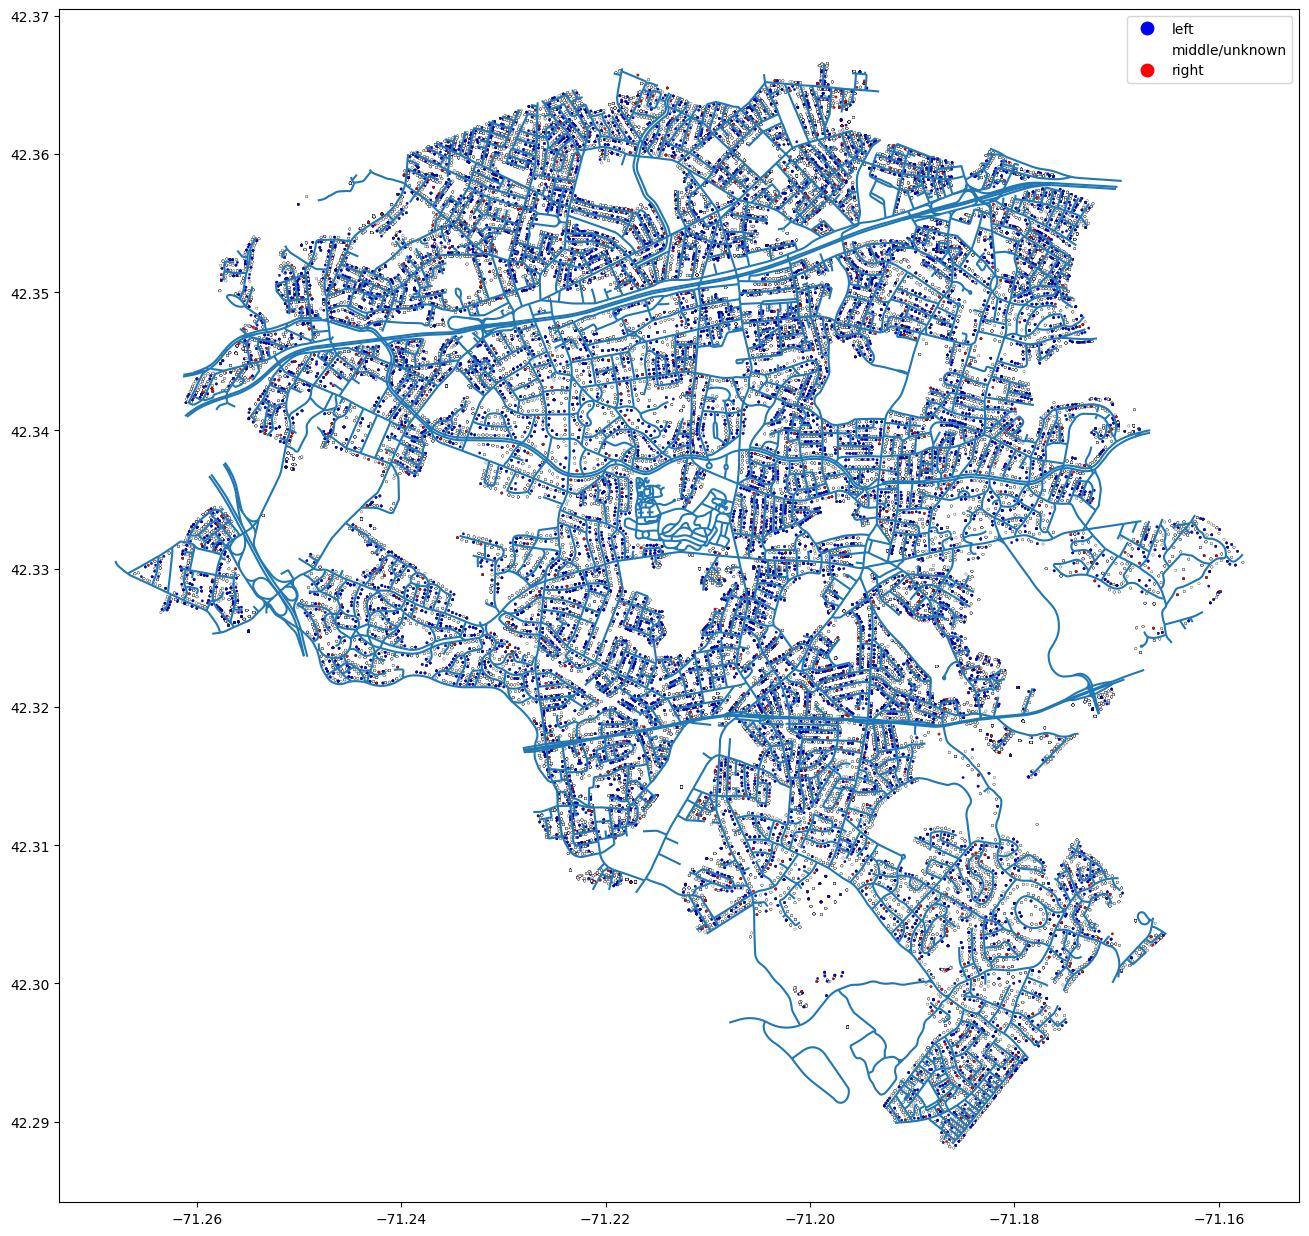

In [265]:
voter_gdf.fillna("", inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
street_gdf.plot(ax=ax)
voter_gdf.plot(
    ax=ax,
    column="politics",
    cmap="bwr",
    markersize=3,
    edgecolor="k",
    lw=0.2,
    legend=True,
)
lasso = LassoSelector(ax, onselect)

In [302]:
voter_gdf["lat"] = voter_gdf["geometry"].y
voter_gdf["lon"] = voter_gdf["geometry"].x

In [303]:
for c in ["number", "fullstname", "first_name", "last_name"]:
    voter_gdf[c].fillna(" ", inplace=True)

voter_gdf["address"] = [
    str(n) + " " + s for n, s in zip(voter_gdf["number"], voter_gdf["fullstname"])
]
voter_gdf["fullname"] = [
    f + " " + l for f, l in zip(voter_gdf["first_name"], voter_gdf["last_name"])
]

In [308]:
# get age on election day

voter_gdf["age_on_election_day"] = [
    (
        (
            dt.datetime(2025, 11, 4) - convert_to_datetime(x, fmt="%m/%d/%y")
        ).total_seconds()
        / (365.25 * 24 * 60 * 60)
    )
    for x in voter_gdf.date_of_birth
]
voter_gdf["age_on_election_day"] = voter_gdf["age_on_election_day"].apply(floor)

56452

In [335]:
voter_gdf = voter_gdf[
    [
        "addressid",
        "voter_id_number",
        "fullname",
        "address",
        "residential_address_apartment_number",
        "party_affiliation",
        "age_on_election_day",
        "ward",
        "precinct",
        "occupation",
        "nationality",
        "party_name",
        "politics",
        "polling_location",
        "geometry",
        "lat",
        "lon",
    ]
]

## Write out

In [336]:
voter_gdf.drop("geometry", axis=1).to_csv("~/Desktop/voters.csv")
voter_gdf.to_file("~/Desktop/voters.geojson")